# **FastAI Image Classifier**
## **3 classes image classification model**
### Author: Jesús Berríos (jesusfberrios)

The purpose of this project is to classify correctly 3 worldwide recognized awards that are pretty look alike:
- FIFA Golden Ball (Balón de Oro)
- Grammy
- Oscar

![image](https://user-images.githubusercontent.com/81935591/126382106-2ef9c8ba-4961-4915-a664-8384bec38ce6.png)

**This project is a Colab-Based python notebook which has the following phases:**
0. Handle Installation/Libraries
1. Mount Colab Drive to get the files
2. Get images from github
3. Building Data Structures for FastAI model
4. Building Classification Model
5. Classifier confusion matrix
6. Show predictions with greater loss
7. Some random prediction examples

**Overview of working mode**
- Image capture from another online sources is out of the scope of this notebook purposes, that is why we have all the images stored in the github repository https://github.com/jesusfberrios/FastAI_imageClassifier, separated by folders. The images were selected to get better results in the model.
- Lists for all group of images were generated, which are in the lists folder and will be used to download the images to Google Drive.
- This notebook creates a set of folders if not exists to store the downloaded images. After the images are stored we will start the Classification problem.

---
## **0. FastAI installation and import required libraries**
Every time Colab environment is reset fastai needs to be installed

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 188 kB 9.8 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


Importing required libraries:

In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import os
import requests 
from PIL import Image
import time

---
## **1. Allow Colab to access Google Drive Files**
drive.mount function is executed. Executor must go to the URL, allow permission, copy the code and insert it in the textbox in order to allow required permissions and continue working.

In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


Now some variables will be declared to name the folders to be created. Then the folders will be created if they don't exist.

In [9]:
path = '/content/drive/My Drive/'
mainfoldername = '01_Award_Images'
otherfoldername = '01_Award_Images_other'
if mainfoldername not in os.listdir(path):
    os.makedirs(path+mainfoldername)
    os.makedirs(path+otherfoldername)
    os.makedirs(path+mainfoldername+'/balon')
    os.makedirs(path+mainfoldername+'/grammy')
    os.makedirs(path+mainfoldername+'/oscar')
    os.makedirs(path+mainfoldername+'/lists')
    os.makedirs(path+otherfoldername+'/images')
    os.makedirs(path+otherfoldername+'/lists')

---
## **2. Get Images from GitHub**
Images will be obtained from github repository jesusfberrios/FastAI_imageClassifier. For practical purposes you can directly upload to the Drive Folders or get the images from other sources making some little changes in the code.

Get Images procedure overview:
- Obtain images list from github folder (for each image class or folder). Store the list in a dataframe which will be stored in "lists" folder from Drive.
- Obtain the images URL from each dataframe row. Sleep procedure is used to prevent failures in images integrity. This process will take some minutes...

In [10]:
files = ['images','balon','grammy','oscar']

for i in files:
    url = 'https://raw.githubusercontent.com/jesusfberrios/FastAI_imageClassifier/main/lists/list_'+i+'.csv'
    print('csv url = '+url)
    #download_url(url, path+mainfoldername+'/lists/list_'+i+'.csv')
    if i=='images':
        k=otherfoldername
    else:
        k=mainfoldername

    df = pd.read_csv(url,header=None)
    df.to_csv(path+k+'/lists/list_'+i+'.csv')
    print('downloaded csv')
    link_list = df[df.columns[0]].tolist()
    
    for j in range(0,len(link_list)):

        while True:
            response = requests.get(link_list[j])
            file = open(path+k+'/'+i+'/'+str(j)+".jpg", "wb")
            file.write(response.content)
            file.close()
            time.sleep(1)
            print(i+': '+' file='+str(j)+' weight='+str(os.path.getsize(path+k+'/'+i+'/'+str(j)+".jpg")))
            if os.path.getsize(path+k+'/'+i+'/'+str(j)+".jpg")>=500:
                break
            else:
                response = requests.get(link_list[j-1])
                print(path+k+'/'+i+'/'+str(j)+".jpg")
                print(link_list[j])
                time.sleep(5)


csv url = https://raw.githubusercontent.com/jesusfberrios/FastAI_imageClassifier/main/lists/list_images.csv
downloaded csv
images:  file=0 weight=25229
images:  file=1 weight=79304
images:  file=2 weight=31355
images:  file=3 weight=16169
images:  file=4 weight=19944
images:  file=5 weight=81293
csv url = https://raw.githubusercontent.com/jesusfberrios/FastAI_imageClassifier/main/lists/list_balon.csv
downloaded csv
balon:  file=0 weight=8490
balon:  file=1 weight=6374
balon:  file=2 weight=6383
balon:  file=3 weight=9710
balon:  file=4 weight=9964
balon:  file=5 weight=6679
balon:  file=6 weight=5715
balon:  file=7 weight=6701
balon:  file=8 weight=8426
balon:  file=9 weight=8942
balon:  file=10 weight=11793
balon:  file=11 weight=8844
balon:  file=12 weight=7878
balon:  file=13 weight=10650
balon:  file=14 weight=5510
balon:  file=15 weight=10217
balon:  file=16 weight=8064
balon:  file=17 weight=9045
balon:  file=18 weight=8295
balon:  file=19 weight=6690
balon:  file=20 weight=7510


---
## **3. Building Data Structures for FastAI model**
We will use a DataBlock, which works as an API that generates a data assembly with an object-defined structure, among those we have the Dataloaders. The DataBlock defines the data types for the inputs and outputs, label types, train/test split, etc.

In this project we will divithe tre train/test set in 80/20 proportion.

In [11]:
prizes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

Now we will follow the steps in the code:
- Path object is generated on path_ai variable, which is a defined data type input for the DataLoader.
- DataLoader is generated over the declared DataBlock, pointing to the Path object which has the location for the images to use in the model.
- Print some images with their respective labelling according to the declared data structure in the DataBlock (Image, Category), where we can find the category in the name of each folder.

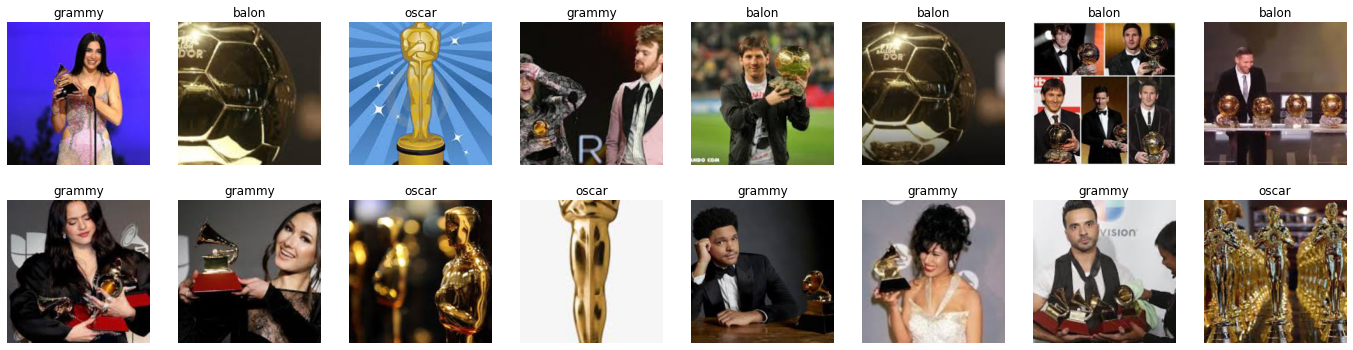

In [12]:
path_ai = Path(path+mainfoldername)
dls = prizes.dataloaders(path_ai)
dls.valid.show_batch(max_n=16, nrows=2)

Then, the model will be fed with some image transformations:
- RandomResizedCrop: It generates some copies of trimmed images with minimum scale proportion of 0.5, which center is random and the resolution is set to 224 pixels.
- Augmentation: It generates transformations for the same images like rotation, mirroring, brightness changes, etc.

In [13]:
prizes = prizes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = prizes.dataloaders(path_ai)

To understand better what was done, there will be shown some unique images after Augmentation and Normalization. We can appreciate the different versions that are generated for the same image:

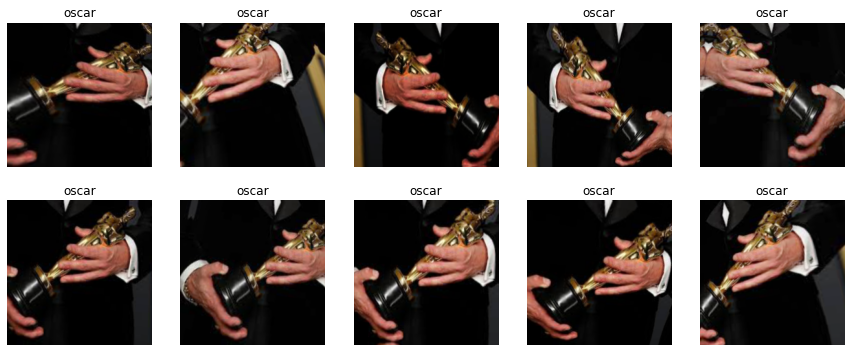

In [14]:
dls.train.show_batch(max_n=10, nrows=2, unique=True)

---
## **4. Building Classification Model**
We will use a Convolutional Neural Network (CNN), which is a model typically used on image classification applications. We will take ResNet34 Architecture as baseline, which has already defined the layer numbers of neural network (34), nodes, structure and learning type (residual for ResNet), so as the weight initialization values.

So, we will initialize the CNN on ResNet34 weights and structure, and the model will be started to be trained from this phase with the GoldenBall/Oscar/Grammy data, that is what we call the **Learning Transfer**. We set 5 epochs in order to expect having an error rate less than 0.1.

In [15]:
learn = cnn_learner(dls, models.resnet34, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.202984,0.271399,0.101562,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.396235,0.221398,0.070312,00:04
1,0.320268,0.210669,0.062500,00:04
2,0.263925,0.195521,0.070312,00:04
3,0.207182,0.199560,0.070312,00:04
4,0.175473,0.195534,0.062500,00:04


As expected, we have obtained an error rate for less than 0.1 in some minutes which is pretty good!

According to the experience obtained executing this project, it is very important to have a high quality training set, at least at the point that as humans we can distinguish the respective class of the image.

---
## **5. Classifier Confusion Matrix**

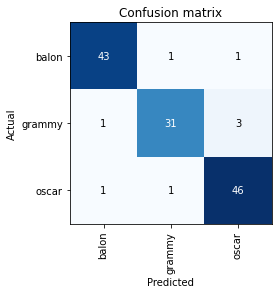

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can observe in the confusion matrix that the numbers that are not in the main diagonal are the wrong-predicted values, and we can appreciate which class can be more "confused" with other one more than the rest of errors.

---
## **6. Showing prediction with greater loss**
We will show 5 predictions which have the greater loss:

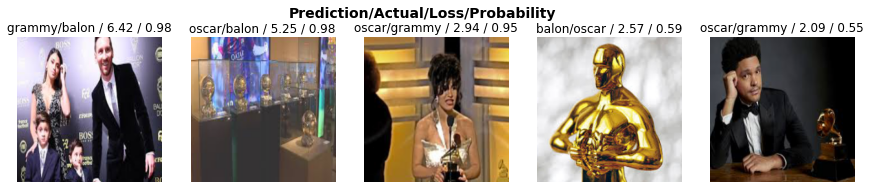

In [17]:
interp.plot_top_losses(5, nrows=1)

Showing this you can infer what is the reason for the classes to be "confused" between each other. Some random reasons can be:
- How the people is dressed
- By some resizing the award can be stretched and confused with another
- The background
- Image zoom
- Among others

---
## **7. Prediction Examples**
Below we show some prediction examples which are not in the train/test datased that we worked, so we can really appreciate visually the result of the classification model.

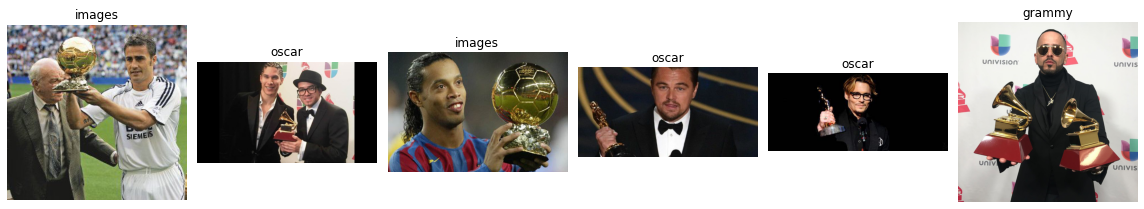

In [ ]:
def vis_imlist(path):
    #Se genera lista de imágenes asociadas a la ruta
    image_list = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]
    #Se ordenan alfabéticamente
    image_list.sort()
    #Se generan subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize = (16,8))
    
    #Se despliegan las imágenes en un mismo gráfico
    for i in range(0,len(image_list)):
        ax = axes[i]
        im = np.array(Image.open(image_list[i]))
        ax.imshow(im)
        pred_class,pred_idx,outputs = learn.predict(im)
        ax.axis("off")
        ax.set_title(str(pred_class))
    fig.tight_layout()

#Se ejecuta la función
vis_imlist(path+otherfoldername+'/images/')